# **Assignment 3: Presentation of EU procurement networks**

Author: Kai Foerster <br>
ID: 214288 <br>
Date: 23 November 2023

# Disclaimer and References:
This work would not have been possible without EU procurement data provided under: https://networks.skewed.de/net/eu_procurements_alt. <br>
Much of the interpretation is based on work presented in: Wachs, J., Fazekas, M. & Kertész, J. Corruption risk in contracting markets: a network science perspective. Int J Data Sci Anal 12, 45–60 (2021). https://doi.org/10.1007/s41060-019-00204-1 <br>
Finally, this work would not be possible without intense discussion between classmates and through the help of online forums, and OpenAI's ChatGPT which has helped in debugging and describing the code.

# Introduction

In this project, we examine the networks of public procurement contracts across various EU nations, drawing on a portion of the dataset used by Wachs, Fazekas, and Kertész in their 2020 study, "Corruption risk in contracting markets: a network science perspective." The complete eu_procurements_alt dataset encompasses 234 networks, each depicting the yearly procurement activities of 26 European countries over the period from 2008 to 2016. This information originates from the Tenders Electronic Daily (TED), which is the EU's official portal for public procurement. Each network consists of issuers and winners of procurement contracts.  Each of these networks is structured as a bipartite graph, with edges symbolizing the contract awards between issuers and winners. To proceed with our analysis, additional steps will be taken to properly handle the bipartite structure inherent in these networks. <br>

An integral part of our analysis will involve exploring the temporal dynamics of these networks. By examining the networks over time, we can gain insights into how the relationships and structures within these procurement systems evolve, potentially revealing patterns or trends in the data. Furthermore, we will compare these real-world networks to established network models, such as the Barabási–Albert model, to understand better how they conform to or deviate from theoretical expectations. This comparison will enable us to contextualize our findings within the broader landscape of network theory. Additionally, link prediction techniques will be employed to forecast potential future connections within these networks, offering a predictive lens through which we can assess the networks' future development and identify potential areas of risk or concern. This comprehensive approach, encompassing temporal analysis, theoretical comparison, and predictive modeling, will provide a robust framework for understanding the complex web of interactions within EU public procurement networks.

# Motivation and choice of countries and years

While the comprehensive dataset includes data for 26 EU countries, this analysis narrows its focus to four specific countries: **xxx**, **Cyprus**, **Denmark**, and **Bulgaria**. The rationale for this selection is twofold: Firstly, these countries have comparatively smaller network sizes, which simplifies the computational process. Secondly, by analyzing only the years **xxx** and **xxx**, we cover a significant span of time while also reducing complexity. This approach strikes a balance between computational feasibility and the breadth of the analysis.

In the context of corruption indicators, like the average single bidding rate used by Wachs, Fazekas, and Kertész, the chosen countries offer a diverse range of network behaviors. Cyprus and Bulgaria are included for their higher perceived levels of corruption, potentially offering insights into how such traits manifest in network structure. Conversely, Denmark, often considered a standard for low corruption levels, and Austria, which sits in the middle, provide contrasting examples. The selection aims to yield a better understanding of network properties in relation to different corruption levels, with the possibility of extending the analysis to additional countries and years for a more comprehensive study in the future.

![Wachs, Fazekas, and Kertész (2021) |  Fig 1](attachment:Figure 1.png)

Figure 1: Single-bidding rates on procurement contracts on TED, 2008–2016 by country, retrieved from Wachs et al. (2021)

# Importing and manipulating the data for further analysis
Note on running this .ipynb file: This file is running using graph-tool installed on the wsl:Ubuntu (Linux for Windows). Before running this file you will need to install graph-tool to your PC (different methods for Windows and Mac) or configure graph-tool on Google Colab. Below you find commented out, code to configure graph-tool in Google Colab. Instructions on how to install graph-tool on Windows or Mac can be found on the graph-tool website: https://graph-tool.skewed.de/static/doc/index.html#installing-graph-tool (Last accessed: 8 November 2023)

In [ ]:
# %%capture
# !echo "deb http://downloads.skewed.de/apt jammy main" >> /etc/apt/sources.list
# !apt-key adv --keyserver keyserver.ubuntu.com --recv-key 612DEFB798507F25
# !apt-get update
# !apt-get install python3-graph-tool python3-matplotlib python3-cairo

In [ ]:
# %%capture
# !apt purge python3-cairo
# !apt install libcairo2-dev pkg-config python3-dev
# !pip install --force-reinstall pycairo
# !pip install zstandard

In [6]:
# Import graph tool libraries
import graph_tool.all as gt

In [7]:
# Import other libraries
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import os
import matplotlib.image as mpimg
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.colors as colors
import networkx as nx
from networkx.algorithms import bipartite

In [8]:
# Import data on eu procurement contracts from Netzschleuder using graph tool and save the networks in the dictionary datasets

# Select the countries and years you want to retrieve
countries_years = [
    ('IE', '2008'),
    ('IE', '2009'),
    ('IE', '2010'),
    ('IE', '2011'),
    ('IE', '2012'),
    ('IE', '2013'),
    ('IE', '2014'),
    ('IE', '2015'),
    ('IE', '2016')
]

# Create a dictionary to hold your data
datasets = {}

# Iterate over each country/year pair and retrieve the corresponding dataset
for country_code, year in countries_years:
    dataset_name = f"{country_code}_{year}"  # This will be the key, e.g., 'AT_2016'
    full_dataset_name = f"eu_procurements_alt/{dataset_name}"  # This is the full path used to retrieve the dataset from Netzschleuder
    datasets[dataset_name] = gt.collection.ns[full_dataset_name]

# Now we have a dictionary where the keys are 'AT_2016', 'CY_2008', etc., and the values are the data you've retrieved

In [9]:
# Convert the graph-tool networks stored in datasets to networkx networks stored in datasets_nx
# Note: Given that graph-tool and networkx are different libraries, we need to convert the graph-tool networks to networkx networks
#       in order to use networkx functions. We need the networkx function bipartite.projected_graph() to compute the issuer and winner
#       projections. We also need the networkx function bipartite.is_bipartite() to check whether a graph is bipartite. Doing this
#       conversion is a bit cumbersome, but it's the only way to use networkx functions on graph-tool graphs. The equivalent functions
#       in graph-tool do not exist or must be implemented manually.

# Initialize the new dictionary to hold networkx datasets, saved in datasets_nx
datasets_nx = {}

for dataset_name, g_tool_graph in datasets.items():
    # Initialize a new networkx graph for the current dataset
    G_nx = nx.Graph()

    # Add vertices and their attributes to the networkx graph
    for v in g_tool_graph.vertices():
        # Here, 'v_prop' is a dictionary of the vertex properties
        v_prop = {prop: g_tool_graph.vp[prop][v] for prop in g_tool_graph.vertex_properties.keys()}
        G_nx.add_node(v, **v_prop)

    # Add edges and their attributes to the networkx graph
    for e in g_tool_graph.edges():
        # Here, 'e_prop' is a dictionary of the edge properties
        e_prop = {prop: g_tool_graph.ep[prop][e] for prop in g_tool_graph.edge_properties.keys()}
        G_nx.add_edge(e.source(), e.target(), **e_prop)

    # Add the networkx graph to the new datasets dictionary
    datasets_nx[dataset_name] = G_nx

# Now `datasets_nx` contains all the networkx graphs corresponding to the graph-tool graphs

In [12]:
# Create the issuer and winner projections using networkx functions. Then convert to projections in networkx format
# back to graph-tool format and save the networks in the dictionary datasets_prj. In the dictionary datasets_prj,
# the keys are the names of the projections and the values are the projections themselves. The keys are named after
# country name, year, and projection type (issuer or winner). For example, the key 'AT_2016_issuer' corresponds to
# the issuer projection of the network for Austria in 2016.


datasets_prj = {}  # This dictionary will store the projections

# Function to create and return both issuer and winner projections from the eu procurement bipartite graphs
def create_projections(G):
    issuers_set = {n for n, d in G.nodes(data=True) if d['label'].endswith('_i')}
    winners_set = {n for n, d in G.nodes(data=True) if d['label'].endswith('_w')}

    # Create the bipartite projections
    issuer_projection = bipartite.projected_graph(G, issuers_set)
    winner_projection = bipartite.projected_graph(G, winners_set)

    return issuer_projection, winner_projection

# Function to convert a networkx graph to a graph-tool graph
def convert_networkx_to_graphtool(G_nx, name_description):
    G_gt = gt.Graph(directed=False)
    pos_property = G_gt.new_vertex_property("vector<double>")
    label_property = G_gt.new_vertex_property("string")
    vertex_map = {node: G_gt.add_vertex() for node in G_nx}
    for node, data in G_nx.nodes(data=True):
        v = vertex_map[node]
        pos_property[v] = data.get('_pos', [0.0, 0.0])
        label_property[v] = data['label']
    for u, v in G_nx.edges():
        G_gt.add_edge(vertex_map[u], vertex_map[v])

    # Set the graph name and description properties
    G_gt.graph_properties["name"] = G_gt.new_graph_property("string", name_description[0])
    G_gt.graph_properties["description"] = G_gt.new_graph_property("string", name_description[1])

    return G_gt, pos_property, label_property

# Loop over each network in datasets_nx
for dataset_key, G_nx in datasets_nx.items():
    # Split the key to get country and year
    country, year = dataset_key.split('_')

    # Create the projections
    issuer_projection, winner_projection = create_projections(G_nx)

    # Convert projections to graph-tool format
    name_description = (f"eu_procurements_alt ({country}_{year}_issuer)",
                        "Issuer projection of the bipartite graph")
    datasets_prj[f"{country}_{year}_issuer"], _, _ = convert_networkx_to_graphtool(issuer_projection, name_description)

    name_description = (f"eu_procurements_alt ({country}_{year}_winner)",
                        "Winner projection of the bipartite graph")
    datasets_prj[f"{country}_{year}_winner"], _, _ = convert_networkx_to_graphtool(winner_projection, name_description)


In [13]:
# Function to draw a graph-tool graph using the edge properties 'count' and 'pctSingleBid'. Here, 'count' is the number of contracts
# between two nodes and 'pctSingleBid' is the percentage of contracts between two nodes that were single-bid contracts. 'count' is used
# as weight for the edge pen width and 'pctSingleBid' is used to color the edges where the edges become more red as the percentage of
# single-bid contracts increases, i.e. goes from 0 to 1. The vertex color is determined by the vertex type, i.e. 'issuer' or 'winner'.
# The vertex type is determined by the vertex label, which ends with '_i' for issuers and '_w' for winners. The vertex outline is black
# for all vertices. The vertex pen width is set to 1.2. The function returns a dictionary with the drawing parameters.

def draw_weighted_colored_graph(u, edge_color_property_name='edge_color'):
    """
    Prepares edge color, pen width, and vertex color based on 'count', 'pctSingleBid',
    and vertex type ('issuer' or 'winner').
    Designed to be used within gt.graph_draw.
    :param u: The graph for which the drawing parameters are being prepared.
    :param edge_color_property_name: The name to be assigned to the new edge color property.
    :return: A dictionary with the edge_color, edge_pen_width, vertex_fill_color, and vertex_outline properties.
    """
    # Retrieve the 'count' and 'pctSingleBid' edge properties
    edge_count = u.ep["count"]
    edge_pctSingleBid = u.ep["pctSingleBid"]

    # Create a new edge property for the matplotlib color mapping
    edge_color = u.new_edge_property('vector<double>')
    u.ep[edge_color_property_name] = edge_color

    # Create color maps and normalization instance for edges
    cmap = plt.get_cmap('coolwarm')
    norm = colors.Normalize(vmin=0, vmax=1)  # 'pctSingleBid' is between 0 and 1

    # Assign colors to edges based on 'pctSingleBid' values
    for e in u.edges():
        normalized_value = norm(edge_pctSingleBid[e])
        edge_color[e] = cmap(normalized_value)

    # Prepare vertex color properties
    vertex_fill_color = u.new_vertex_property('vector<double>')
    vertex_outline = u.new_vertex_property('vector<double>')  # For the boundary

    # Check the vertex 'label' property and assign colors accordingly
    for v in u.vertices():
        label = u.vp.label[v]
        if label.endswith("_i"):  # Check if the vertex label ends with '_i'
            vertex_fill_color[v] = [0.5, 0.5, 0.5, 1]  # Gray for issuers
        elif label.endswith("_w"):  # Check if the vertex label ends with '_w'
            vertex_fill_color[v] = [1, 1, 1, 1]  # White for winners
        vertex_outline[v] = [0, 0, 0, 1]  # Black outline for all vertices

    # Prepare the dictionary with drawing parameters
    drawing_parameters = {
        'edge_color': edge_color,
        'edge_pen_width': gt.prop_to_size(edge_count, mi=0.5, ma=25, power=1),
        'vertex_fill_color': vertex_fill_color,
        'vertex_color': vertex_outline,  # This is for the boundary
        'vertex_pen_width': 1.2  # Adjust the pen width as needed
    }

    return drawing_parameters


# Temporal analysis

In [14]:
# Ensure the output directory exists
output_dir = "fdp_layout_temp"
os.makedirs(output_dir, exist_ok=True)

In [15]:
# Loop through each dataset and save the graph as an image
for dataset_key, g in datasets.items():
    u = gt.extract_largest_component(g, prune=True)
    pos = gt.sfdp_layout(u)
    output_path = os.path.join(output_dir, f"{dataset_key}.png")
    drawing_parameters = draw_weighted_colored_graph(u)
    gt.graph_draw(u, pos, output=output_path, **drawing_parameters)

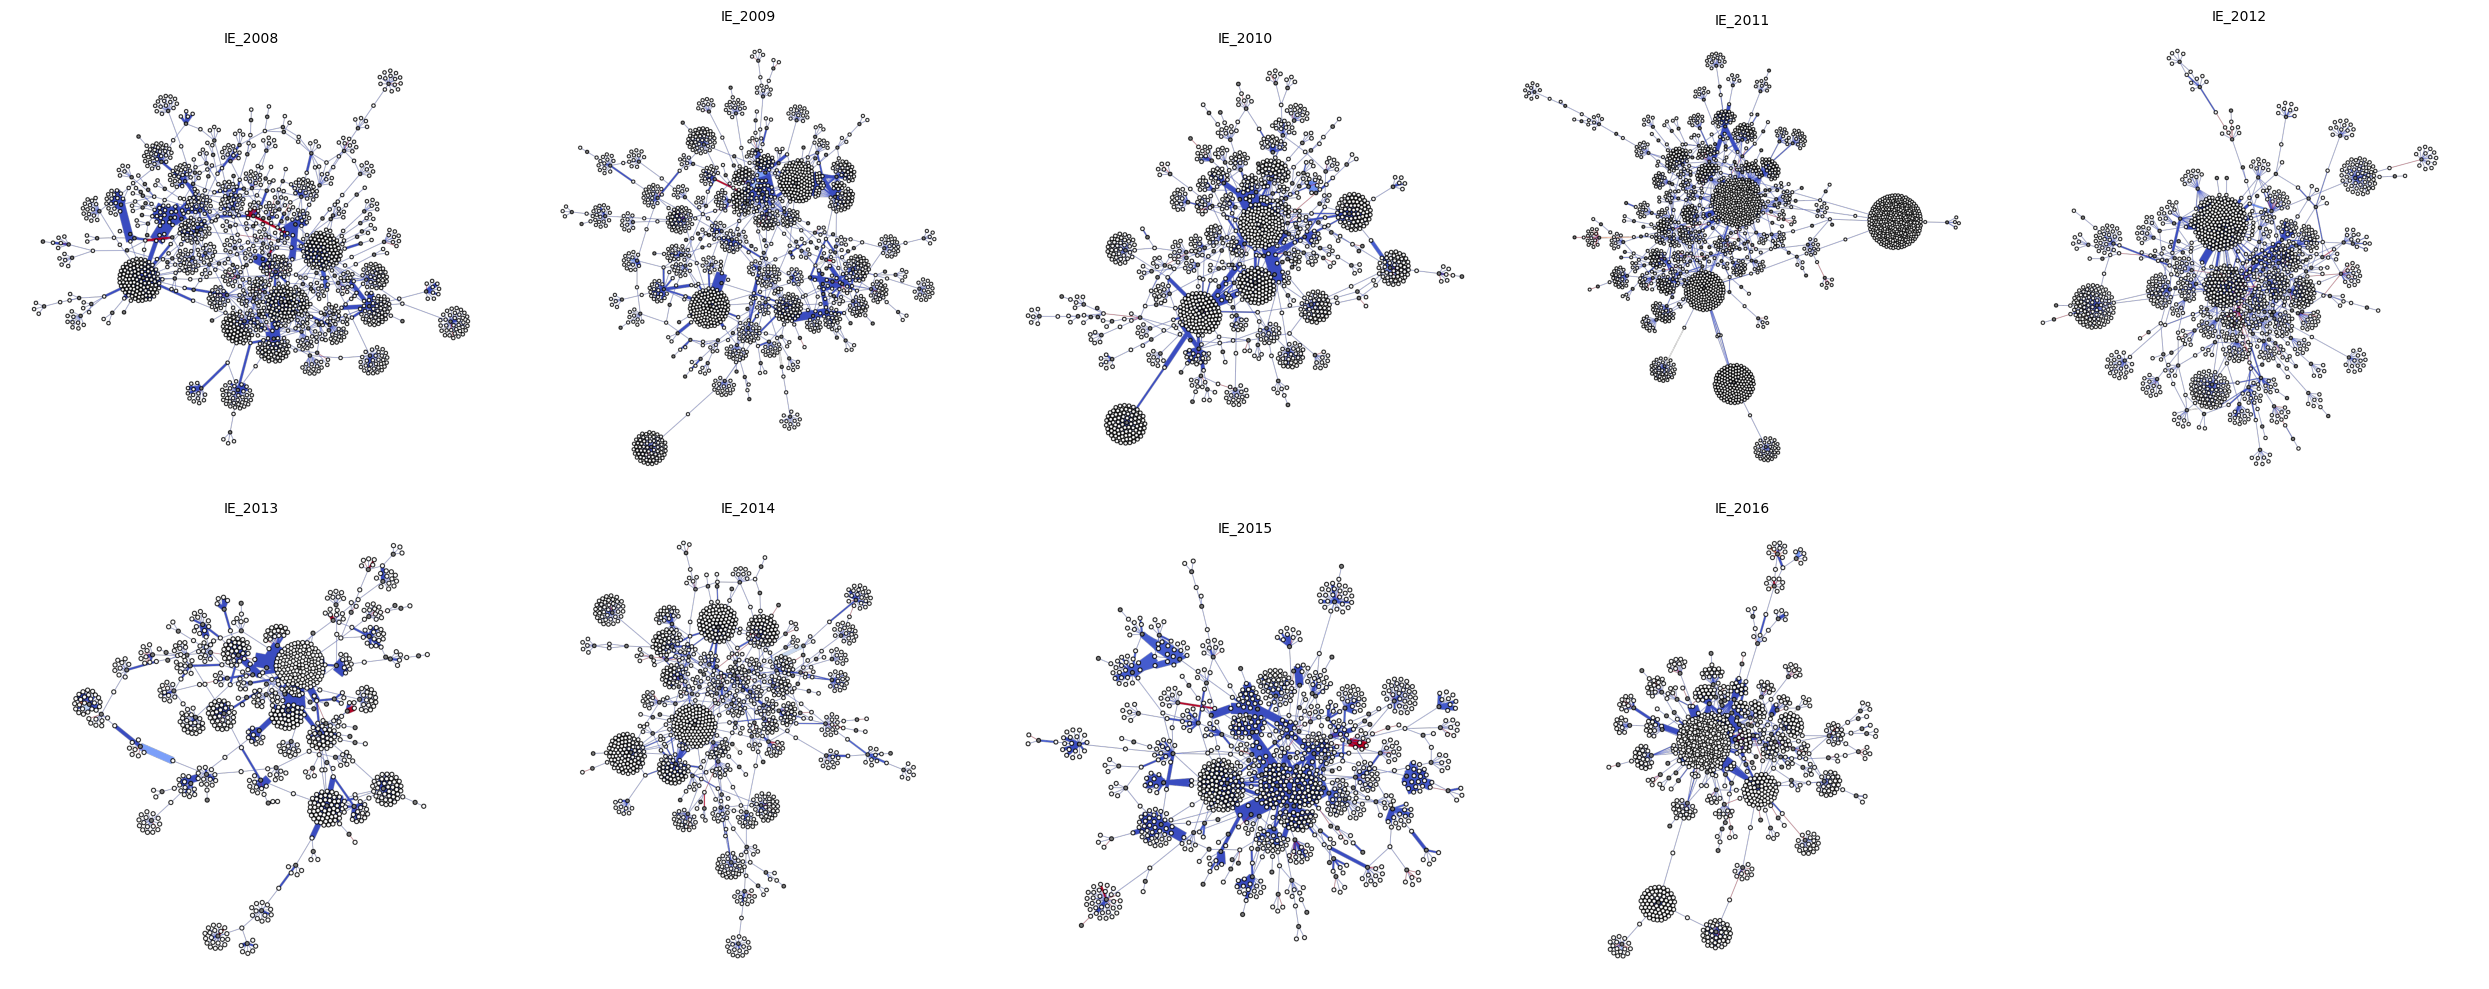

In [17]:
# Get the list of all saved images
image_files = sorted([os.path.join(output_dir, f) for f in os.listdir(output_dir) if f.endswith('.png')])

# Calculate the number of rows and columns for the facet wrap
cols = 5
rows = int(np.ceil(len(image_files) / float(cols)))

# Create the figure with subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))

# Flatten the axes array for easy iteration, in case of a 2D axes array
axes = axes.flatten()

# Loop through each image file and add it to the subplot
for i, image_file in enumerate(image_files):
    img = mpimg.imread(image_file)
    axes[i].imshow(img)
    axes[i].axis('off')  # Turn off the axis
    # Set the title for the subplot using the filename
    axes[i].set_title(image_file.split('/')[-1].replace('.png', ''), fontsize=10)

# Hide any unused subplots if the number of plots isn't a perfect grid
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout and display
plt.tight_layout()
plt.show()


# Comparison to established network models

# Link Prediction

Link prediction in network analysis is a task where you predict which nodes in a network are likely to form a connection. This can be useful in various domains, such as social networks, biology, and information networks. Python libraries like NetworkX and graph-tool offer tools and algorithms to facilitate this task. Here's a basic overview of how you can perform link prediction using these libraries. <br>

In a bipartite network, the nodes are divided into two disjoint sets, and every edge connects a node from one set to a node from the other set. In your case, one set consists of issuers and the other of winners, and an edge represents a contract awarded from an issuer to a winner. When doing link prediction in such a network, you're right that there are inherent restrictions: issuers should only be connected to winners and not to other issuers, and similarly, winners should only be connected to issuers. <br>

For link prediction in bipartite networks, the same general methods (like Common Neighbors, Jaccard Coefficient, etc.) can be used, but with a focus on predicting links between the two different sets of nodes. Here's how you can adapt the approach:


### Using NetworkX
NetworkX is a Python library for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks. It has several built-in functions that can be used for link prediction. Common strategies include:

**Common Neighbors**: Two nodes are more likely to form a link if they have many common neighbors. <br>
**Jaccard Coefficient**: Similar to common neighbors but normalized by the total number of neighbors. <br>
**Adamic/Adar Index**: Weighs common neighbors by their degree. <br>
**Preferential Attachment**: Nodes with higher degree are more likely to form links. <br>

NetworkX has support for bipartite networks and includes some tools that can be useful. However, when you calculate metrics like common neighbors or Jaccard coefficients, you should only consider pairs of nodes from different sets (i.e., an issuer and a winner, but never two issuers or two winners).

Here's an example using NetworkX, adapted for a bipartite network:

In [ ]:
## general code for link prediction
import networkx as nx

# Create a graph
G = nx.Graph()
# Add some nodes and edges
# ...

# Common Neighbors
for u, v, p in nx.common_neighbors(G, u, v):
    print(f"({u}, {v}) -> {p}")

# Jaccard Coefficient
for u, v, p in nx.jaccard_coefficient(G):
    print(f"({u}, {v}) -> {p}")

# Adamic/Adar Index
for u, v, p in nx.adamic_adar_index(G):
    print(f"({u}, {v}) -> {p}")

# Preferential Attachment
for u, v, p in nx.preferential_attachment(G):
    print(f"({u}, {v}) -> {p}")


In [ ]:
## specific to bipartite graphs
import networkx as nx
from networkx.algorithms import bipartite

# Create a bipartite graph
B = nx.Graph()
# Add nodes with the bipartite attribute
# Assume 0 for issuers and 1 for winners
# ...

# Example: Add nodes and edges
# B.add_node('Issuer1', bipartite=0)
# B.add_node('Winner1', bipartite=1)
# B.add_edge('Issuer1', 'Winner1')
# ...

# Identify the two sets of nodes
issuers, winners = bipartite.sets(B)

# Common Neighbors (only considering edges between issuers and winners)
for issuer in issuers:
    for winner in winners:
        common = len(set(B.neighbors(issuer)) & set(B.neighbors(winner)))
        print(f"({issuer}, {winner}) -> {common} common neighbors")

# Other metrics like Jaccard Coefficient can be calculated similarly
# ensuring that the pairs are always one issuer and one winner

### Key Considerations

1. **Projection**: Sometimes, it's useful to create a projection of the bipartite network. This means creating two separate networks: one for issuers and one for winners, where nodes are connected if they share a common partner in the other set. However, for direct link prediction between issuers and winners, you usually don't need this step.

2. **Custom Algorithms**: Depending on your specific requirements or the characteristics of your network, you might need to develop custom link prediction algorithms. This could involve adapting existing algorithms or creating new metrics that are particularly suited to the structure and dynamics of your network.

3. **Data Preprocessing**: Ensure your data accurately represents the bipartite nature of the network. Any errors in the classification of nodes (as either issuers or winners) can significantly impact the results of your link prediction analysis.

4. **Validation**: It's essential to validate your predictions, if possible, by comparing them with actual data (e.g., contracts awarded after the period covered by your dataset). This can help you assess the effectiveness of your chosen methods and refine your approach.

### Using graph-tool
graph-tool is another Python library for manipulation and statistical analysis of graphs. It's known for its efficiency, thanks to its C++ core. However, it doesn't have as many built-in link prediction functions as NetworkX. You often need to implement these algorithms yourself. But here's a basic template:

In [ ]:
import graph_tool.all as gt

# Create a graph
g = gt.Graph()
# Add some vertices and edges
# ...

# Implement a link prediction algorithm
# For example, you might calculate common neighbors manually
def common_neighbors(g, u, v):
    neighbors_u = set(g.vertex(u).out_neighbours())
    neighbors_v = set(g.vertex(v).out_neighbours())
    return len(neighbors_u & neighbors_v)

# Iterate over non-edges and predict links
for u in g.vertices():
    for v in g.vertices():
        if u != v and not g.edge(u, v):
            score = common_neighbors(g, u, v)
            print(f"({u}, {v}) -> {score}")
